# Python implementation with mixed integer linear program

```{custom_download_link} https://surfdrive.surf.nl/files/index.php/s/8DNGkJs54KzEnLB/download
:text: "All code + datasets"
:replace_default: "True"
```

```{note}
Gurobi cannot be loaded in this online book, so download this notebook to work on it with Gurobi locally installed.Instruction on how to do that are in the `README.md` and `PA_2_4_A_gurobilicious.ipynb` of week 2.4.
```

```{admonition} MUDE Exam Information
:class: tip, dropdown
The road network design problem serves as an example for solving a complex optimization problem. You're not expected to understand the problem details for the exam.
```

## Data preprocessing

We use some networks from the well-known transportation networks for benchmarking repository as well as a small toy network for case studies of NDPs. The following functions read data from this repository and perform data preprocessing to have the input and the parameters required for our case studies.

In [54]:
# import required packages
import os
import time
import gurobipy as gp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [55]:
# read network file, a function to import the road networks
def read_net(net_file):
    """
       read network file
    """

    net_data = pd.read_csv(net_file, skiprows=8, sep='\t')
    # make sure all headers are lower case and without trailing spaces
    trimmed = [s.strip().lower() for s in net_data.columns]
    net_data.columns = trimmed
    # And drop the silly first and last columns
    net_data.drop(['~', ';'], axis=1, inplace=True)

    # make sure everything makes sense (otherwise some solvers throw errors)
    net_data.loc[net_data['free_flow_time'] <= 0, 'free_flow_time'] = 1e-6
    net_data.loc[net_data['capacity'] <= 0, 'capacity'] = 1e-6
    net_data.loc[net_data['length'] <= 0, 'length'] = 1e-6
    net_data.loc[net_data['power'] <= 1, 'power'] = int(4)
    net_data['init_node'] = net_data['init_node'].astype(int)
    net_data['term_node'] = net_data['term_node'].astype(int)
    net_data['b'] = net_data['b'].astype(float)

    # extract features in dict format
    links = list(zip(net_data['init_node'], net_data['term_node']))
    caps = dict(zip(links, net_data['capacity']))
    fftt = dict(zip(links, net_data['free_flow_time']))
    lent = dict(zip(links, net_data['length']))
    alpha = dict(zip(links, net_data['b']))
    beta = dict(zip(links, net_data['power']))

    net = {'capacity': caps, 'free_flow': fftt, 'length': lent, 'alpha': alpha, 'beta': beta}

    return net


# read OD matrix (demand), a function to import Origin and Destination Matrices, 
# that is a table that says how many vehicles go from i to j
def read_od(od_file):
    """
       read OD matrix
    """

    f = open(od_file, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        origs = int(orig[0])

        d = [eval('{' + a.replace(';', ',').replace(' ', '') + '}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[origs] = destinations
    zones = max(matrix.keys())
    od_dict = {}
    for i in range(zones):
        for j in range(zones):
            demand = matrix.get(i + 1, {}).get(j + 1, 0)
            if demand:
                od_dict[(i + 1, j + 1)] = demand
            else:
                od_dict[(i + 1, j + 1)] = 0

    return od_dict


# read case study data, we will have different case studies that have different demand and road network 
def read_cases(networks, input_dir):
    """
       read case study data
    """

    # dictionaries for network and OD files
    net_dict = {}
    ods_dict = {}

    # selected case studies
    if networks:
        cases = [case for case in networks]
    else:
        # all folders available (each one for one specific case)
        cases = [x for x in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, x))]

    # iterate through cases and read network and OD
    for case in cases:
        mod = os.path.join(input_dir, case)
        mod_files = os.listdir(mod)
        for i in mod_files:
            # read network
            if i.lower()[-8:] == 'net.tntp':
                net_file = os.path.join(mod, i)
                net_dict[case] = read_net(net_file)
            # read OD matrix
            if 'TRIPS' in i.upper() and i.lower()[-5:] == '.tntp':
                ods_file = os.path.join(mod, i)
                ods_dict[case] = read_od(ods_file)

    return net_dict, ods_dict


# create node-destination demand matrix
def create_nd_matrix(ods_data, origins, destinations, nodes):
    # create node-destination demand matrix (not a regular OD!)
    demand = {(n, d): 0 for n in nodes for d in destinations}
    for r in origins:
        for s in destinations:
            if (r, s) in ods_data:
                demand[r, s] = ods_data[r, s]
    for s in destinations:
        demand[s, s] = - sum(demand[j, s] for j in origins)

    return demand


Now that we have the required functions for reading and processing the data, let's define some problem parameters and prepare the input. 

In [56]:
# define parameters, case study (network) list and the directory where their files are
extension_factor = 2  # capacity after extension (1.5 means add 50% of existing capacity)
extension_max_no = 40  # max number of links to add capacity to (simplified budget limit)
timelimit = 300  # seconds
beta = 2  # parameter to use in link travel time function (explained later)

networks_dir = 'input/TransportationNetworks'


# prep data
net_dict, ods_dict = read_cases(networks, networks_dir)
# Let's load the network and demand (OD matrix) data of the first network (SiouxFalls) to two dictionaries for our first case study.
# Reminding that we are using the SiouxFalls network which is one of the most used networks in transportation reserach: https://github.com/bstabler/TransportationNetworks/blob/master/SiouxFalls/Sioux-Falls-Network.pdf
net_data, ods_data = net_dict[networks[0]], ods_dict[networks[0]]

## now let's prepare the data in a format readable by gurobi

# prep links, nodes, and free flow travel times
links = list(net_data['capacity'].keys())
nodes = np.unique([list(edge) for edge in links])
fftts = net_data['free_flow']

# auxiliary parameters (dict format) to keep the problem linear (capacities as parameters rather than variables)
# this is the capacity of a road link in vehicles per hour without the expansion
cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
#with the expansion
cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}

# origins and destinations
origs = np.unique([orig for (orig, dest) in list(ods_data.keys())])
dests = np.unique([dest for (orig, dest) in list(ods_data.keys())])

# demand in node-destination form
# an OD-matrix is built
demand = create_nd_matrix(ods_data, origs, dests, nodes)

C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_7368\2029668135.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_data.loc[net_data['free_flow_time'] <= 0, 'free_flow_time'] = 1e-6
C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_7368\2029668135.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_data.loc[net_data['length'] <= 0, 'length'] = 1e-6
C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_7368\2029668135.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_

### Visualize network

In this section, we'll initially visualize the network using the coordinates of the sample road network, 'SiouxFalls'. Later, we'll employ the same network topology to visualize the upgraded links.

Thankfully, Python offers a highly useful package for visualizing networks called **'networkx'**. We'll leverage some of its features, so:

1. Feel free to explore further functionalities of the **networkx** package in its [documentation](https://networkx.org/documentation/stable/reference/index.html).
2. Our coordinates in this specific example are in **JSON** format. Therefore, don't forget to import the package accordingly.
3. Interested in visualizing other networks? Fantastic! However, you'll need to check the format of your coordinates first. TAs will assist you if you wish to explore further.


The road network that we are using in the assessment is the Sioux Falls which is shown below:

In [57]:
# For visualization
import networkx as nx
import json
from matplotlib.lines import Line2D # this will later be used for highlighting edge colors based on values

from utils.network_visualization import network_visualization
from utils.network_visualization_highlight_link import network_visualization_highlight_links
from utils.network_visualization_upgraded import network_visualization_upgraded

In [58]:
coordinates_path = 'input/TransportationNetworks/SiouxFalls/SiouxFallsCoordinates.geojson'

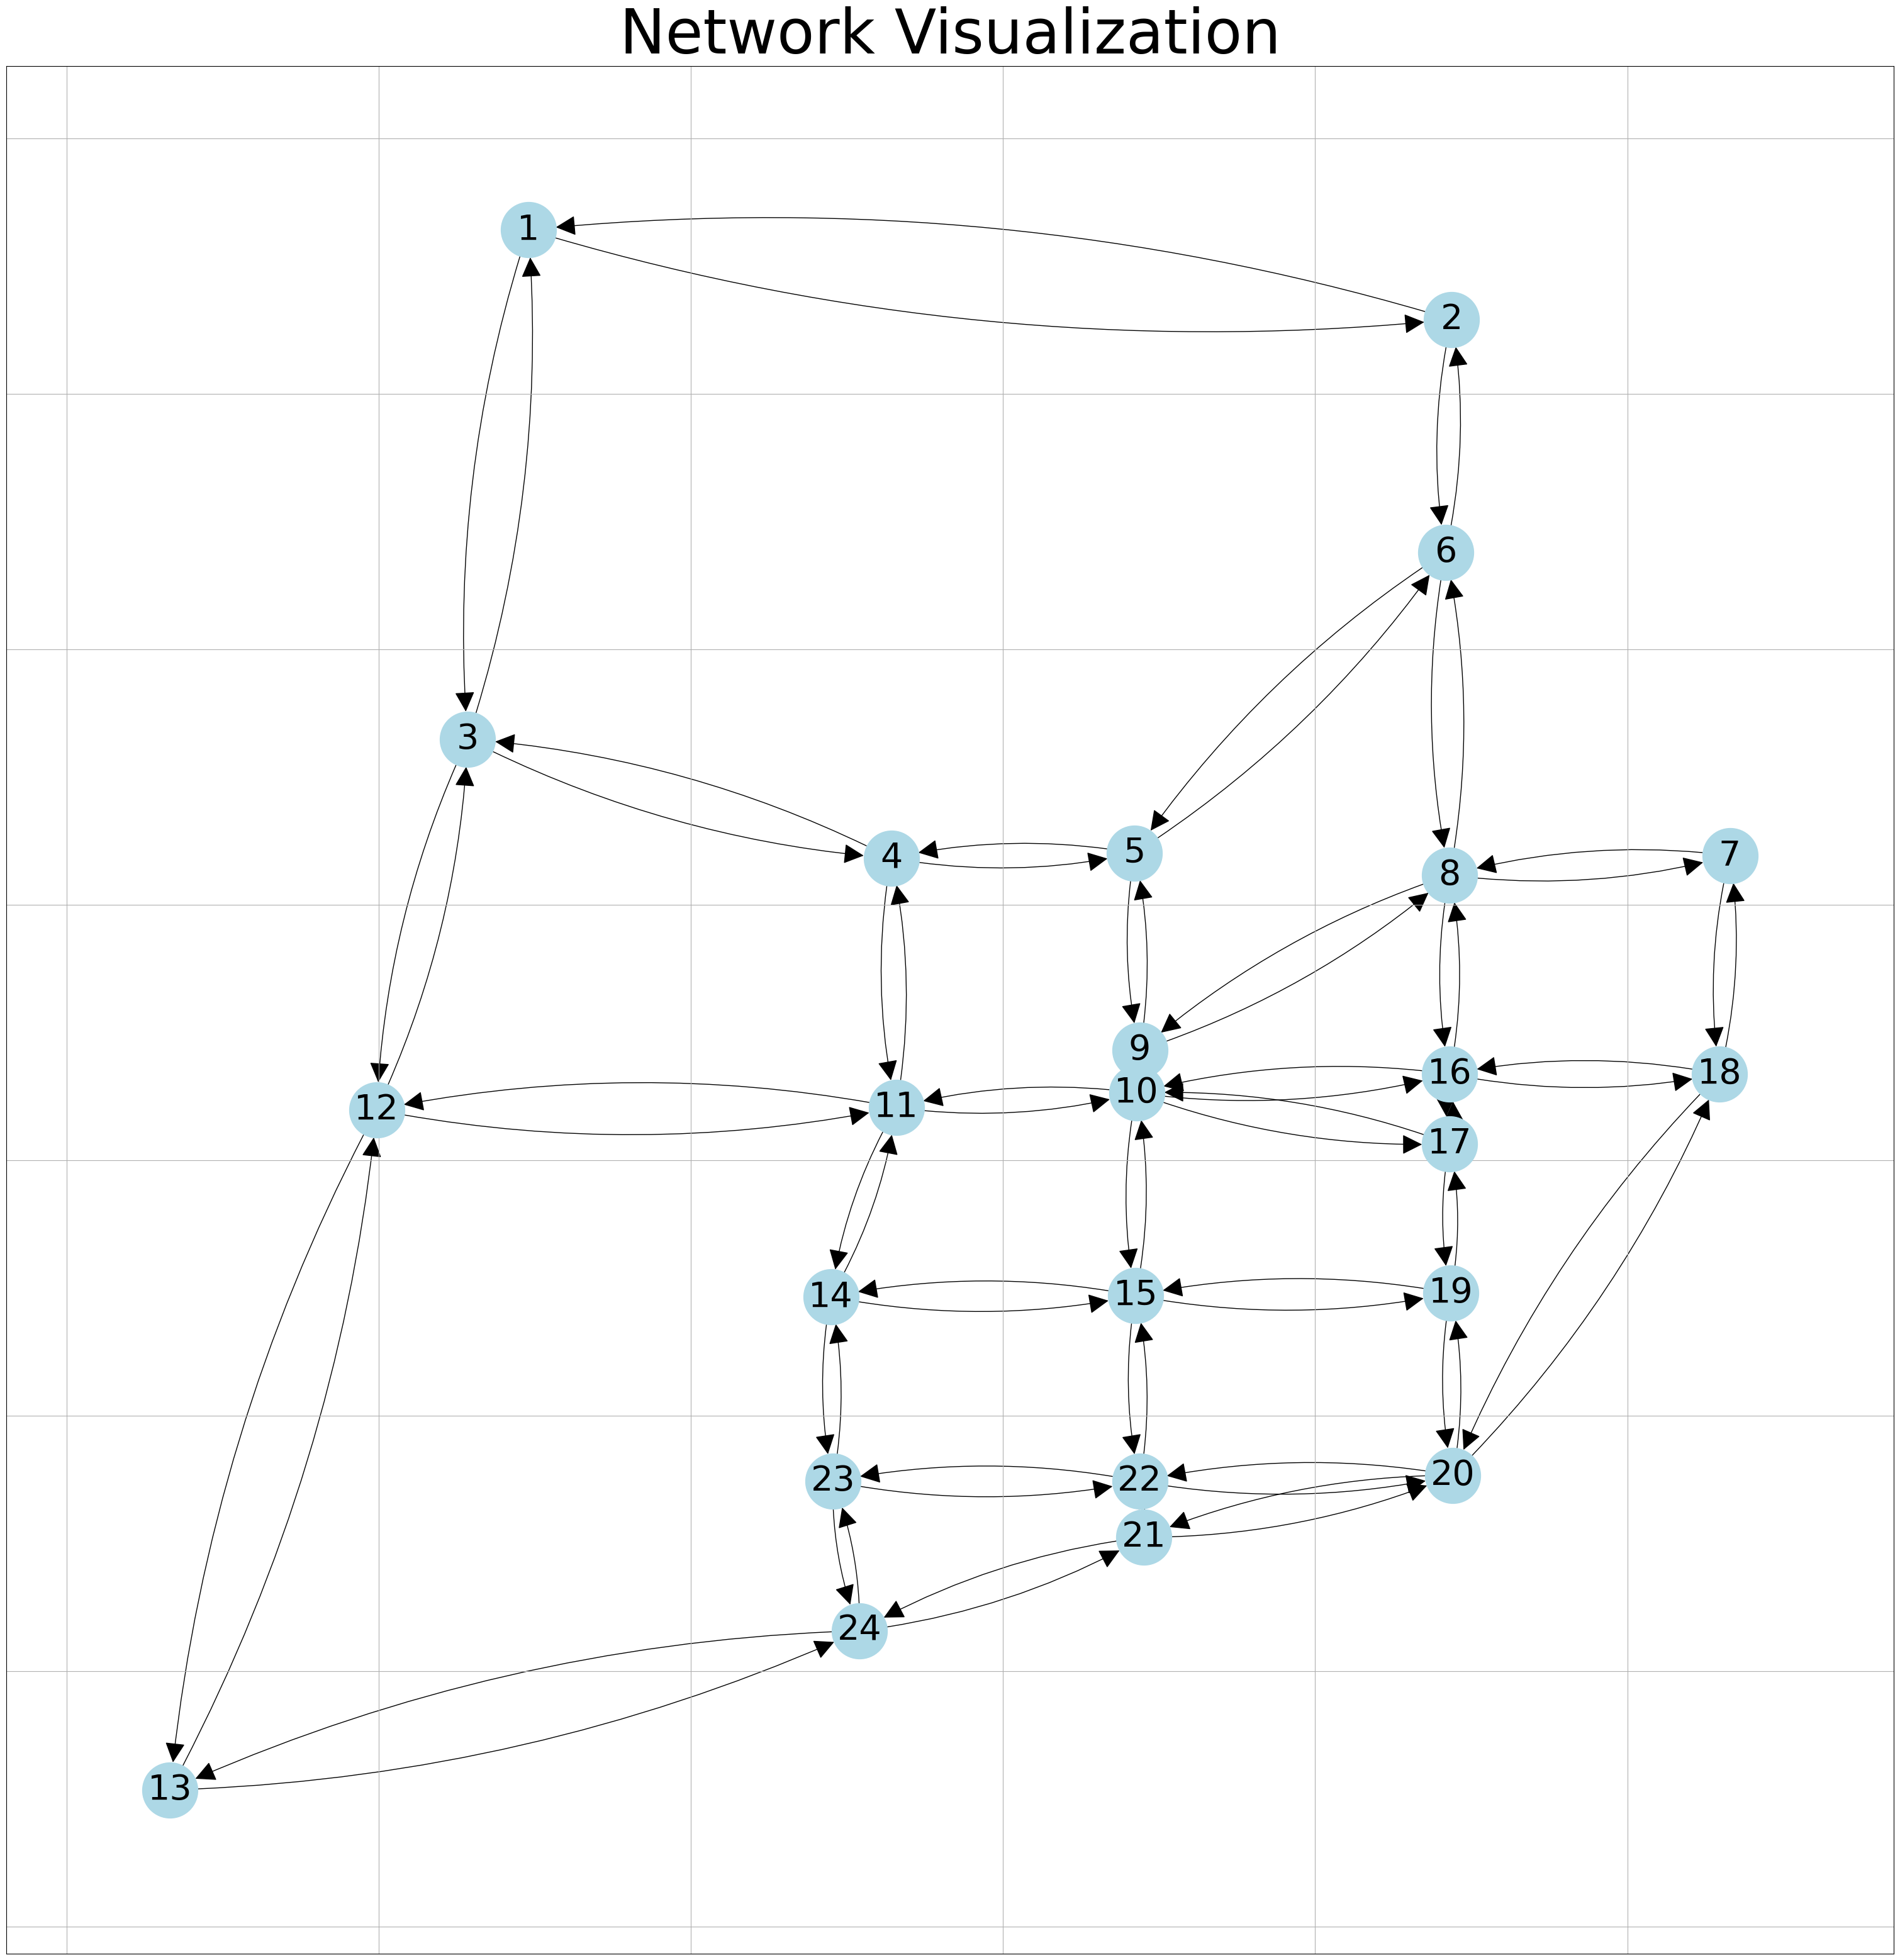

In [59]:
G, pos = network_visualization(link_flow = fftts,coordinates_path= coordinates_path) # the network we create here will be used later for further visualizations!

### OD Matrix

The trips per hour matrix for this network is:


This table is what is called an OD (Origin-Destination) matrix. It tells you how many cars go from node i to node j. The paths are chosen by solving the optimization model.


In [60]:
# Extracting the maximum values for dimensions
data = ods_data
max_origin = max(key[0] for key in data.keys())
max_destination = max(key[1] for key in data.keys())

# Creating a DataFrame to represent the matrix
od_matrix = pd.DataFrame(index=range(1, max_origin + 1), columns=range(1, max_destination + 1))

# Populating the DataFrame with the given data
for key, value in data.items():
    od_matrix.loc[key[0], key[1]] = value

# Displaying the OD matrix in table format
print("Origin-Destination Matrix:")
print(od_matrix.head(5)) # OD matric for the first 5 nodes. 

Origin-Destination Matrix:
      1      2      3      4      5      6      7      8      9       10  ...  \
1      0  100.0  100.0  500.0  200.0  300.0  500.0  800.0  500.0  1300.0  ...   
2  100.0      0  100.0  200.0  100.0  400.0  200.0  400.0  200.0   600.0  ...   
3  100.0  100.0      0  200.0  100.0  300.0  100.0  200.0  100.0   300.0  ...   
4  500.0  200.0  200.0      0  500.0  400.0  400.0  700.0  700.0  1200.0  ...   
5  200.0  100.0  100.0  500.0      0  200.0  200.0  500.0  800.0  1000.0  ...   

      15     16     17     18     19     20     21     22     23     24  
1  500.0  500.0  400.0  100.0  300.0  300.0  100.0  400.0  300.0  100.0  
2  100.0  400.0  200.0      0  100.0  100.0      0  100.0      0      0  
3  100.0  200.0  100.0      0      0      0      0  100.0  100.0      0  
4  500.0  800.0  500.0  100.0  200.0  300.0  200.0  400.0  500.0  200.0  
5  200.0  500.0  200.0      0  100.0  100.0  100.0  200.0  100.0      0  

[5 rows x 24 columns]


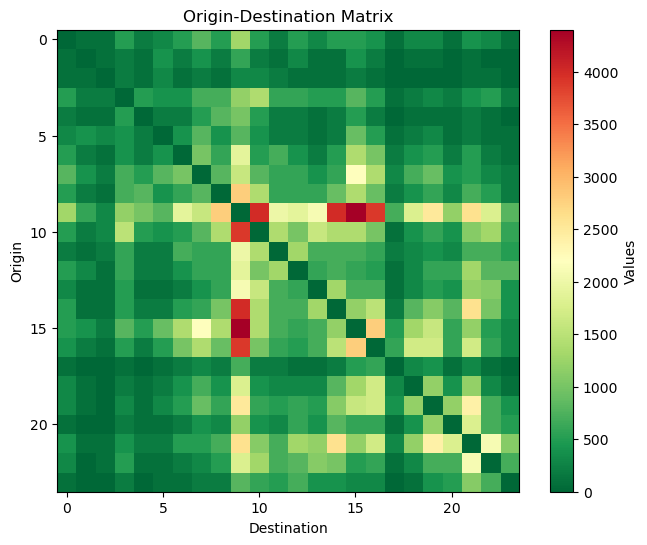

In [61]:
# To better understand the OD matrix we can also visualize the values.
# Creating a subset matrix for visualization
subset_matrix = np.zeros((24, 24))

# Filling subset matrix with data
for i in range(1, 25):
    for j in range(1, 25):
        subset_matrix[i-1, j-1] = data[(i, j)]

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title('Origin-Destination Matrix')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.imshow(subset_matrix, cmap='RdYlGn_r', interpolation='nearest')
plt.colorbar(label='Values')
plt.show()

## Modeling in Gurobi

### Initiate the Gurobi model

First, let's build a Gurobi model object and define some parameters based on the model type. We have a mixed integer quadratic program (MIQP), that's because the objective function has a quadratic term, which we want to transform to a mixed integer linear program (MILP) and solve using the branch and bound method. We discuss the transformations from quadratic to linear when we introduce quadratic terms.

In [62]:
## create a gurobi model object
model = gp.Model()

# define some important parameters for solving the model with gurobi
model.params.TimeLimit = timelimit  # 300 seconds timelimit since it can take long to reduce the gap to zero (change and play around if you want)
model.params.NonConvex = 2  # our problem is not convex as it is now, so we let gurobi know to use the right transformation and solutions
#about convexity in optimization: a convex function will be a continuous functin that will have one minimum 
#(or maximum depending on the problem), therefore in any point that you starting searching for a solution you can follow the gradient 
#to search for that extreme point. Non-convex problems can have local minimum (or maximum) points that will make you stuck in the process 
#of searching for the solution
model.params.PreQLinearize = 1 # useful parameter to ask gurobi to try to linearize non-linear terms

Set parameter TimeLimit to value 300
Set parameter NonConvex to value 2
Set parameter PreQLinearize to value 1


### Decision variables

As you will see below in the code block, we have one extra set of variables called x2 (x square). This is to help Gurobi isolate quadratic terms and perform required transformations based on MCE to keep the problem linear. This is not part of your learning goals.

In [63]:
## decision variables:

# link selected (y_ij); i: a_node, j: b_node (selected links for capacity expansion)
link_selected = model.addVars(links, vtype=gp.GRB.BINARY, name='y')

# link flows (x_ij); i: a_node, j: b_node
link_flow = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x')

# link flows per destination s (xs_ijs); i: a_node, j: b_node, s: destination
dest_flow = model.addVars(links, dests, vtype=gp.GRB.CONTINUOUS, name='xs')

# link flow square (x2_ij); i: a_node, j: b_node (dummy variable for handling quadratic terms, you do not need to know this)
link_flow_sqr = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x2')


### Objective function


In [64]:
## objective function (total travel time)

# total travel time = sum (link flow * link travel time)
# link travel time = free flow travel time * (1 + (flow / capacity))
# capacity = selected links *  base capacity + other links *  extended capacity
# other links: 1 - selected links

#note that this equation allows the number of vehicles to be greater than the capacity, this just adds more penalty in terms of travel time.

model.setObjective(
    gp.quicksum(fftts[i, j] * link_flow[i, j] +
                fftts[i, j] * (beta/cap_normal[i, j]) * link_flow_sqr[i, j] -
                fftts[i, j] * (beta/cap_normal[i, j]) * link_flow_sqr[i, j] * link_selected[i, j] +
                fftts[i, j] * (beta/cap_extend[i, j]) * link_flow_sqr[i, j] * link_selected[i, j]
                for (i, j) in links))

### Constraints

We have four sets of constraints for this problem. Let's go through them one by one and add them to the model.

#### 1. Budget constraint

In [65]:
## constraints

# budget constraints, c_bgt is the name of the constraint
c_bgt = model.addConstr(gp.quicksum(link_selected[i, j] for (i, j) in links) <= extension_max_no)

#### 2. Link flow conservation constraints

In [66]:
# link flow conservation (destination flows and link flows), c_lfc is the name of the constraint
c_lfc = model.addConstrs(gp.quicksum(dest_flow[i, j, s] for s in dests) == link_flow[i, j] for (i, j) in links)

#### 3. Node flow conservation constraints

In [67]:
# node flow conservation (demand), c_nfc is the name of the constraint
c_nfc = model.addConstrs(
    gp.quicksum(dest_flow[i, j, s] for j in nodes if (i, j) in links) -
    gp.quicksum(dest_flow[j, i, s] for j in nodes if (j, i) in links) == demand[i, s]
    for i in nodes for s in dests
)

#### 4. Quadratic variable constraints (you do not need to fully understand this)


In [68]:
# dummy constraints for handling quadratic terms
c_qrt = model.addConstrs(link_flow_sqr[i, j] == link_flow[i, j] * link_flow[i, j] for (i, j) in links)

## Solving the model

In [70]:
3#Next we are ready to solve the model
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 729 rows, 2052 columns and 5776 nonzeros
Model fingerprint: 0xc194c119
Model has 76 quadratic objective terms
Model has 76 quadratic constraints
Variable types: 1976 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e-04, 1e+01]
  QObjective range [2e-04, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 5e+04]
Presolve time: 0.00s
Presolved: 1109 rows, 2280 columns, 6536 nonzeros
Presolved model has 152 SOS constraint(s)
Presolved model has 76 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 2128 continuous, 152 integer (152 binary)

Root relaxat

Note that if you didn't find a solution, you can rerun the previous cell to continue the optimization for another 300 seconds (defined by `timelimit`).

## Analysis

In [71]:
# fetch optimal decision variables and Objective Function values
link_flows = {(i, j): link_flow[i, j].X for (i, j) in links}
links_selected = {(i, j): link_selected[i, j].X for (i, j) in links}
total_travel_time = model.ObjVal

# Let's print right now the objective function
print("Optimal Objective function Value", model.objVal)

# Let's print right now the decision variables
for var in model.getVars():
    print(f"{var.varName}: {round(var.X, 3)}")  # print the optimal decision variable values.

Optimal Objective function Value 9437991.420819432
y[1,2]: 0.0
y[1,3]: 0.0
y[2,1]: 0.0
y[2,6]: 1.0
y[3,1]: 0.0
y[3,4]: 0.0
y[3,12]: 0.0
y[4,3]: 0.0
y[4,5]: 0.0
y[4,11]: 0.0
y[5,4]: 0.0
y[5,6]: 0.0
y[5,9]: 1.0
y[6,2]: 0.0
y[6,5]: 1.0
y[6,8]: 1.0
y[7,8]: 0.0
y[7,18]: 0.0
y[8,6]: 1.0
y[8,7]: 0.0
y[8,9]: 0.0
y[8,16]: 1.0
y[9,5]: 1.0
y[9,8]: 0.0
y[9,10]: 1.0
y[10,9]: 1.0
y[10,11]: 1.0
y[10,15]: 1.0
y[10,16]: 1.0
y[10,17]: 1.0
y[11,4]: 0.0
y[11,10]: 1.0
y[11,12]: 1.0
y[11,14]: 1.0
y[12,3]: 0.0
y[12,11]: 1.0
y[12,13]: 0.0
y[13,12]: 0.0
y[13,24]: 1.0
y[14,11]: 1.0
y[14,15]: 0.0
y[14,23]: 0.0
y[15,10]: 1.0
y[15,14]: 0.0
y[15,19]: 1.0
y[15,22]: 1.0
y[16,8]: 1.0
y[16,10]: 1.0
y[16,17]: 1.0
y[16,18]: 0.0
y[17,10]: 1.0
y[17,16]: 1.0
y[17,19]: 1.0
y[18,7]: 0.0
y[18,16]: 0.0
y[18,20]: 0.0
y[19,15]: 1.0
y[19,17]: 1.0
y[19,20]: 0.0
y[20,18]: 0.0
y[20,19]: 1.0
y[20,21]: 1.0
y[20,22]: 1.0
y[21,20]: 0.0
y[21,22]: 0.0
y[21,24]: 1.0
y[22,15]: 1.0
y[22,20]: 1.0
y[22,21]: 1.0
y[22,23]: 0.0
y[23,14]: 0.0
y[23,

### Network Visualization

#### 1. Network visualization with highlighted links

Now, let's visualize the results showcasing congested traffic flows and the selected links for expansion. 
In this graph, we'll observe the network's topology using node coordinates and links. Our graph will be **directional** to represent the road network.

Nodes are depicted in blue, while selected nodes and links are highlighted in pink and red.

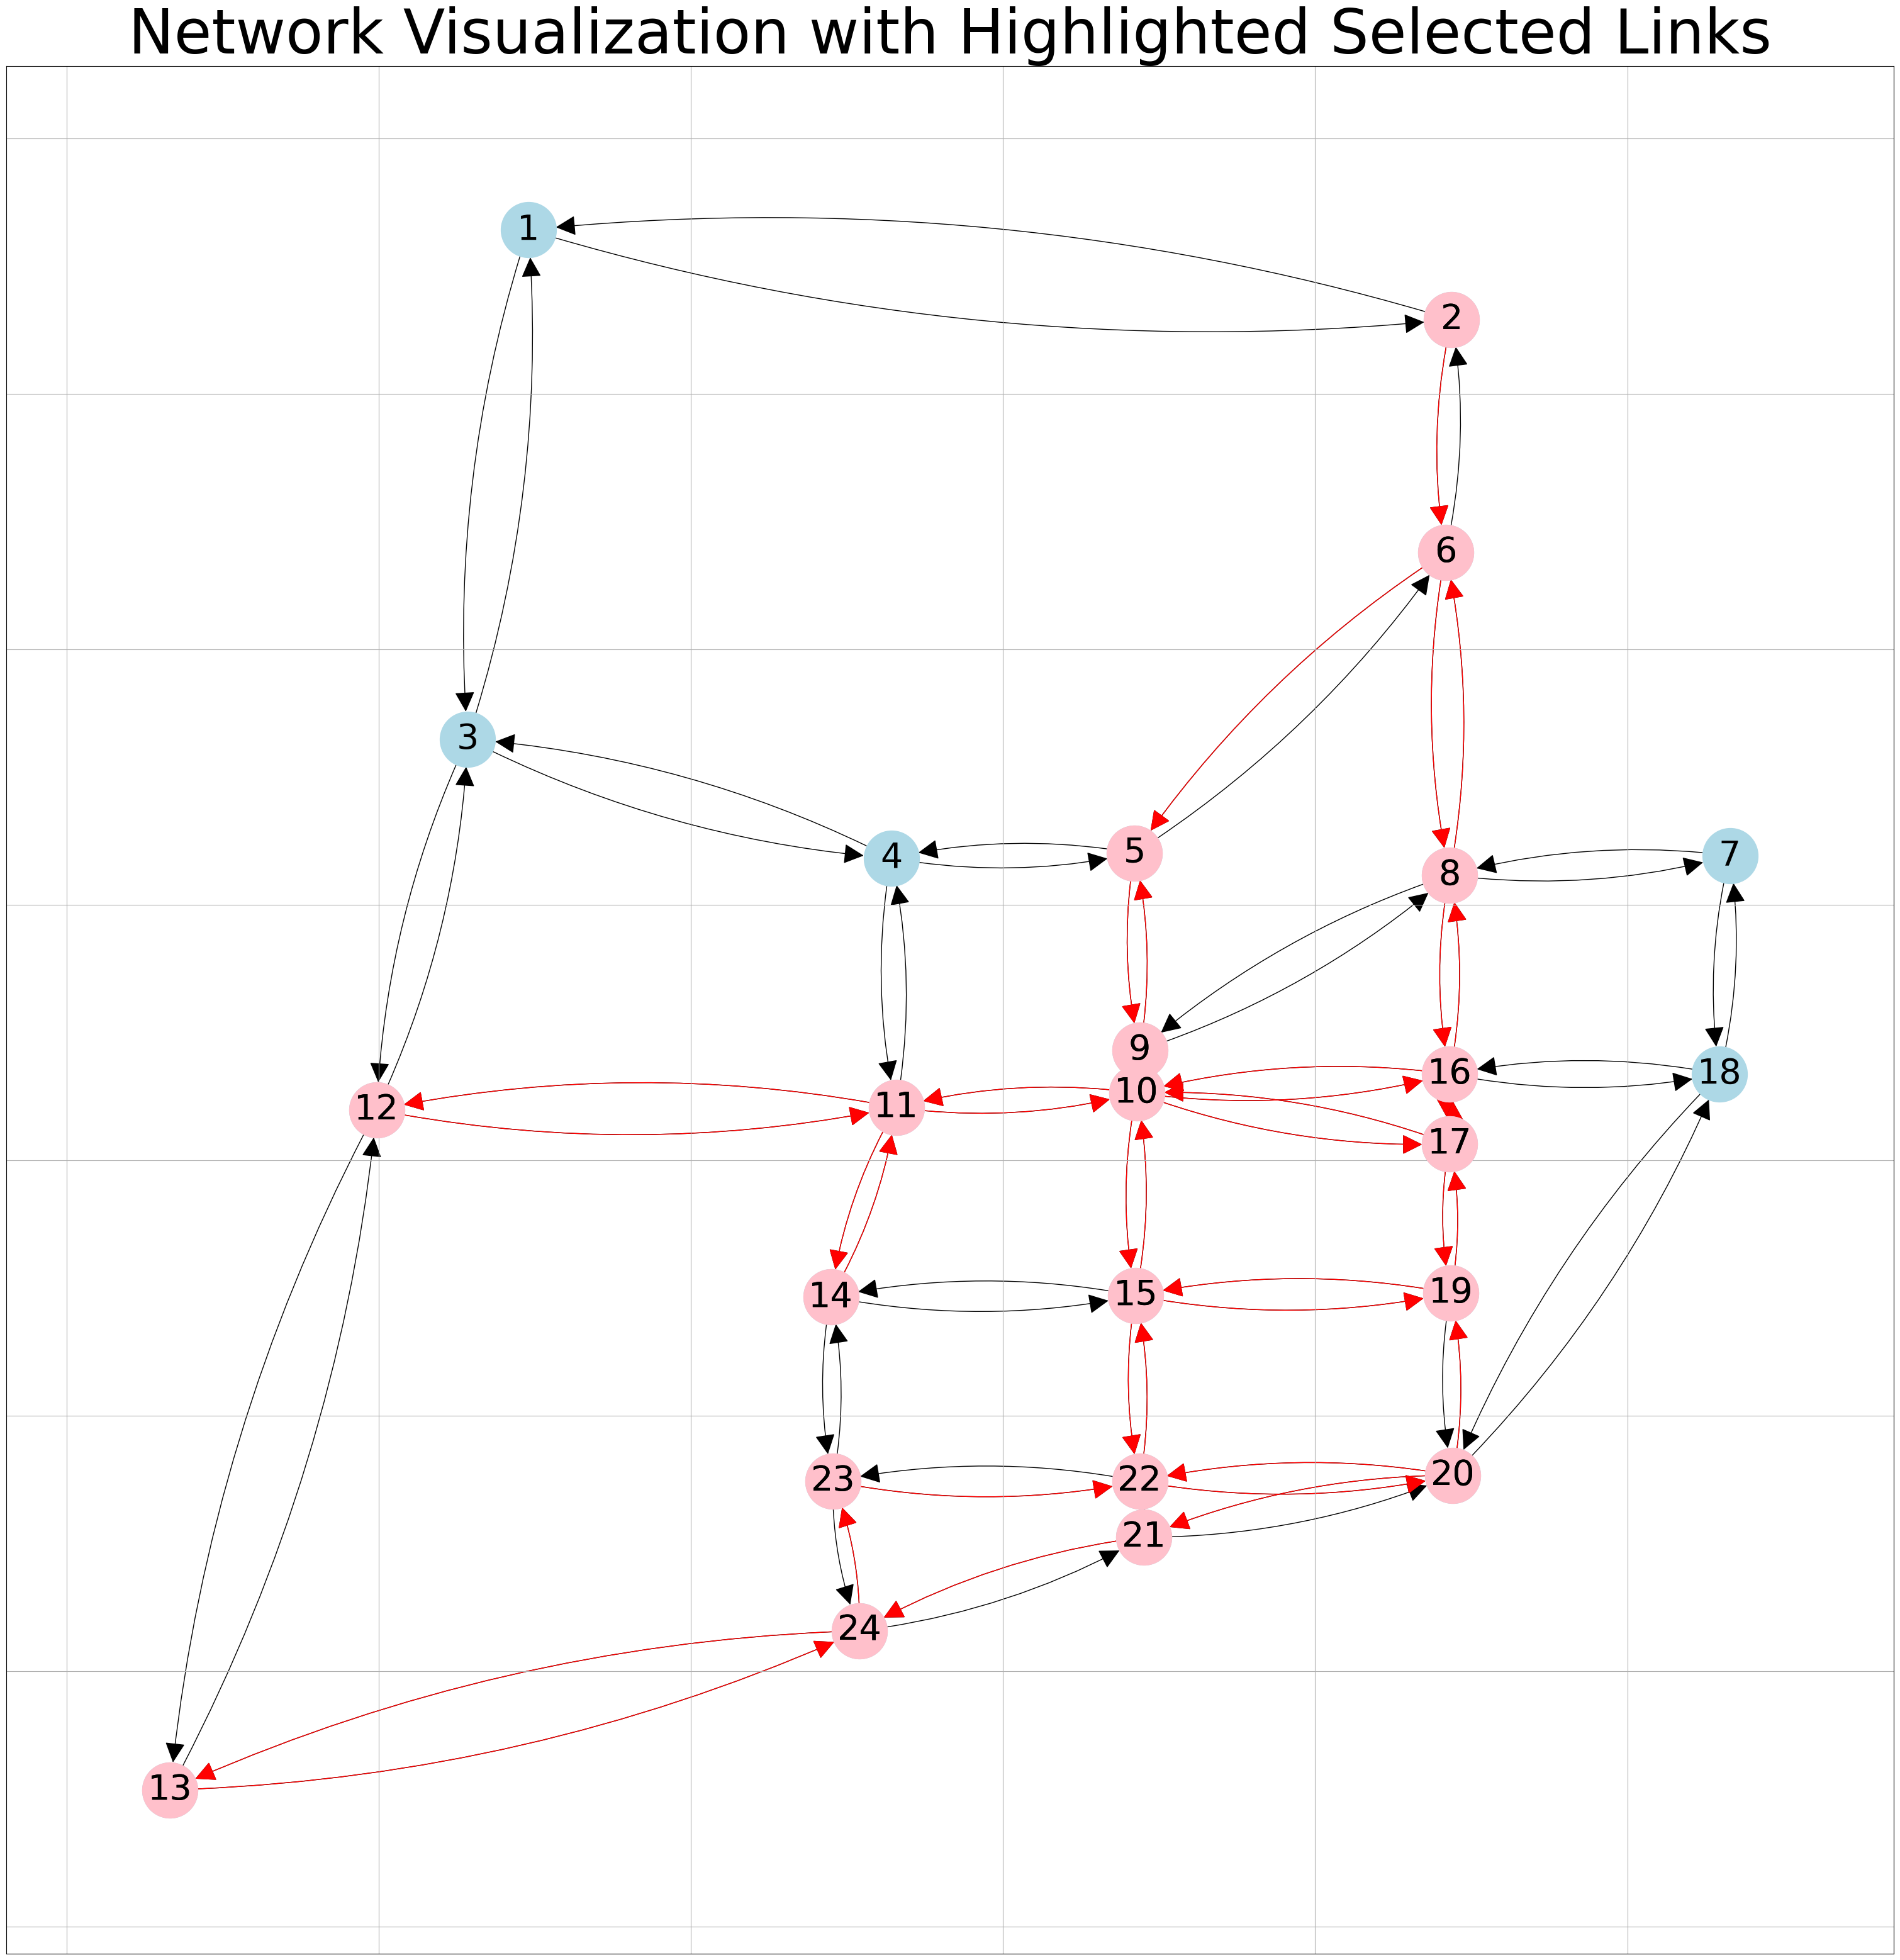

In [72]:
network_visualization_highlight_links (G, pos, link_select=links_selected)

#### 2. Network visualization with upgraded links



In this section, we'll visualize our upgraded network, incorporating the new capacities. Following that, we'll represent the network along with its results, displaying the flow (F) and capacity (C) alongside each link.

**Notes:**

1. **Pink nodes** highlight the selected nodes.
2. **Colored edges** denote the upgraded edges selected through the optimization process.
3. Various **edge colors** indicate different ranges for edge attributes (Flow/Capacity), as demonstrated in the legend.
4. Diverse **edge widths** represent varying flow ranges on the edges.
5. Your plot is interactive; to clearly view the numbers, simply click on them!

In [73]:
# Define new capacity after expansion
cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}
capacity = {(i, j): cap_normal[i, j] * (1 - links_selected[i, j]) + cap_extend[i, j] * links_selected[i, j]
            for (i, j) in links}


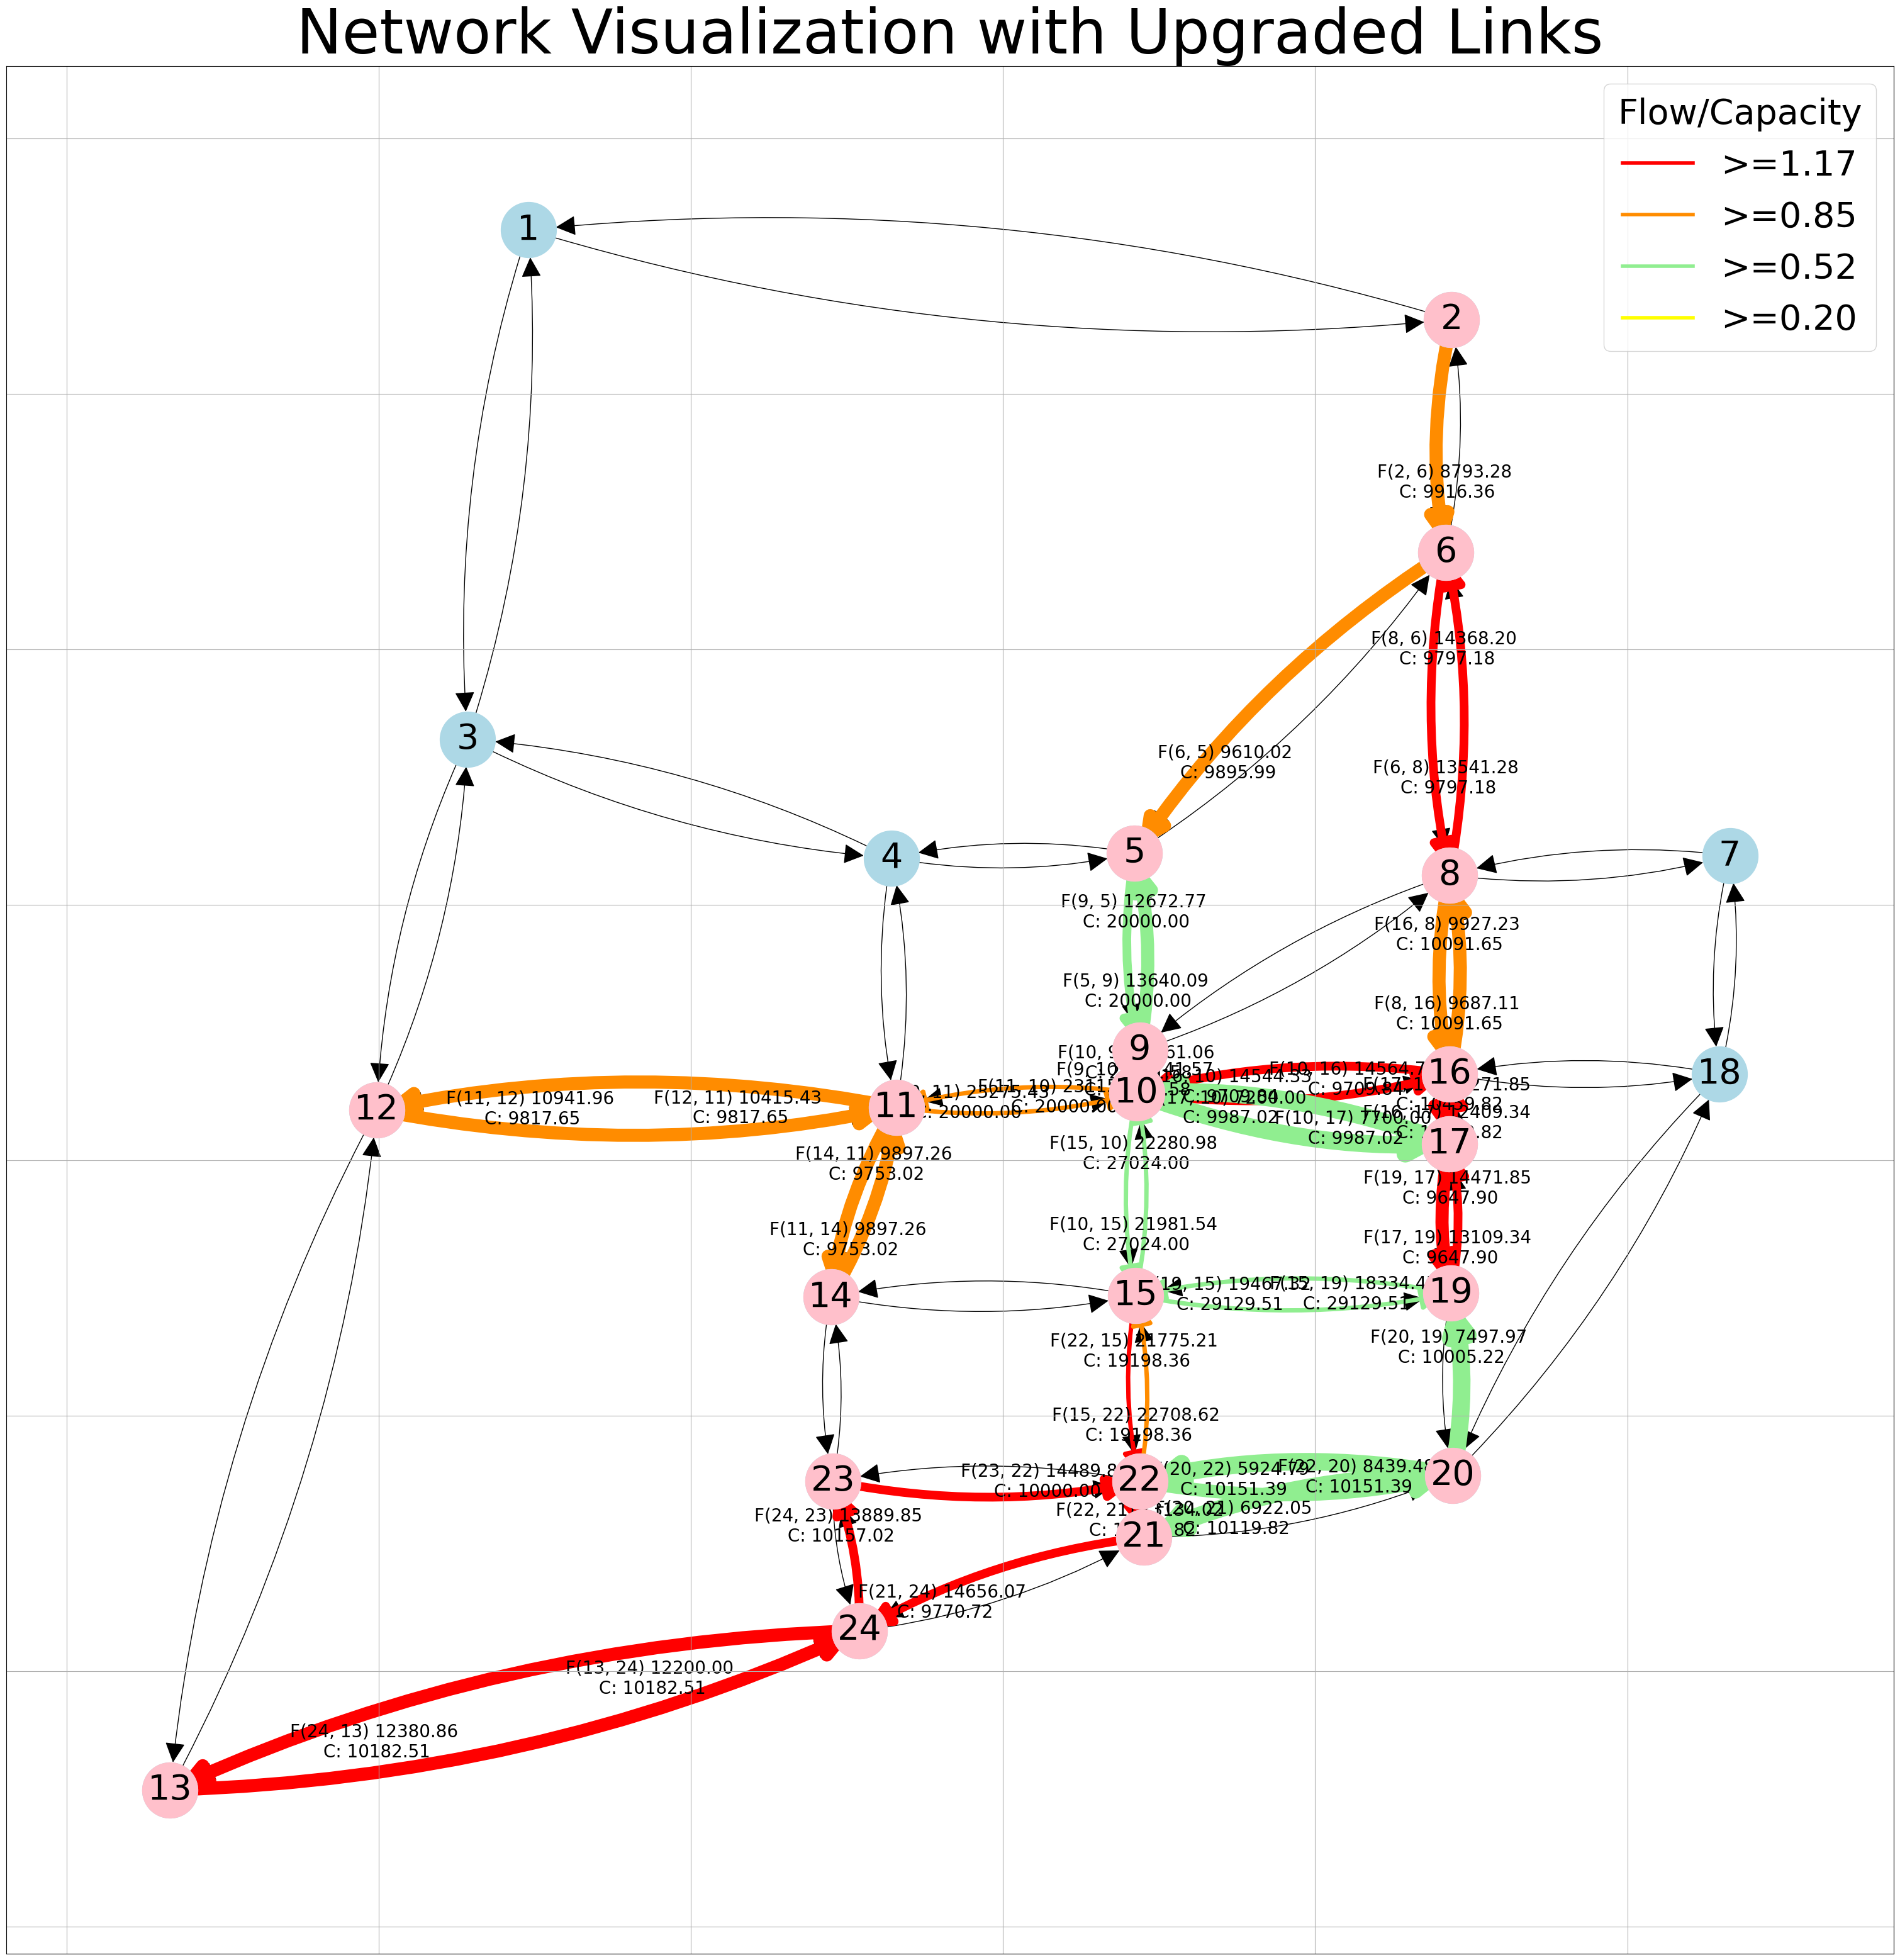

In [74]:
# Plot results
network_visualization_upgraded (G = G, pos=pos, link_flow=link_flows, capacity_new=capacity ,link_select=links_selected, labels='off')

If you wish to see the velues for the entire network you just need to turn on the labels and run the function again. 

C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_7368\4155739783.py:69: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos,edgelist=edge_to_color.keys(), width=edge_widths,


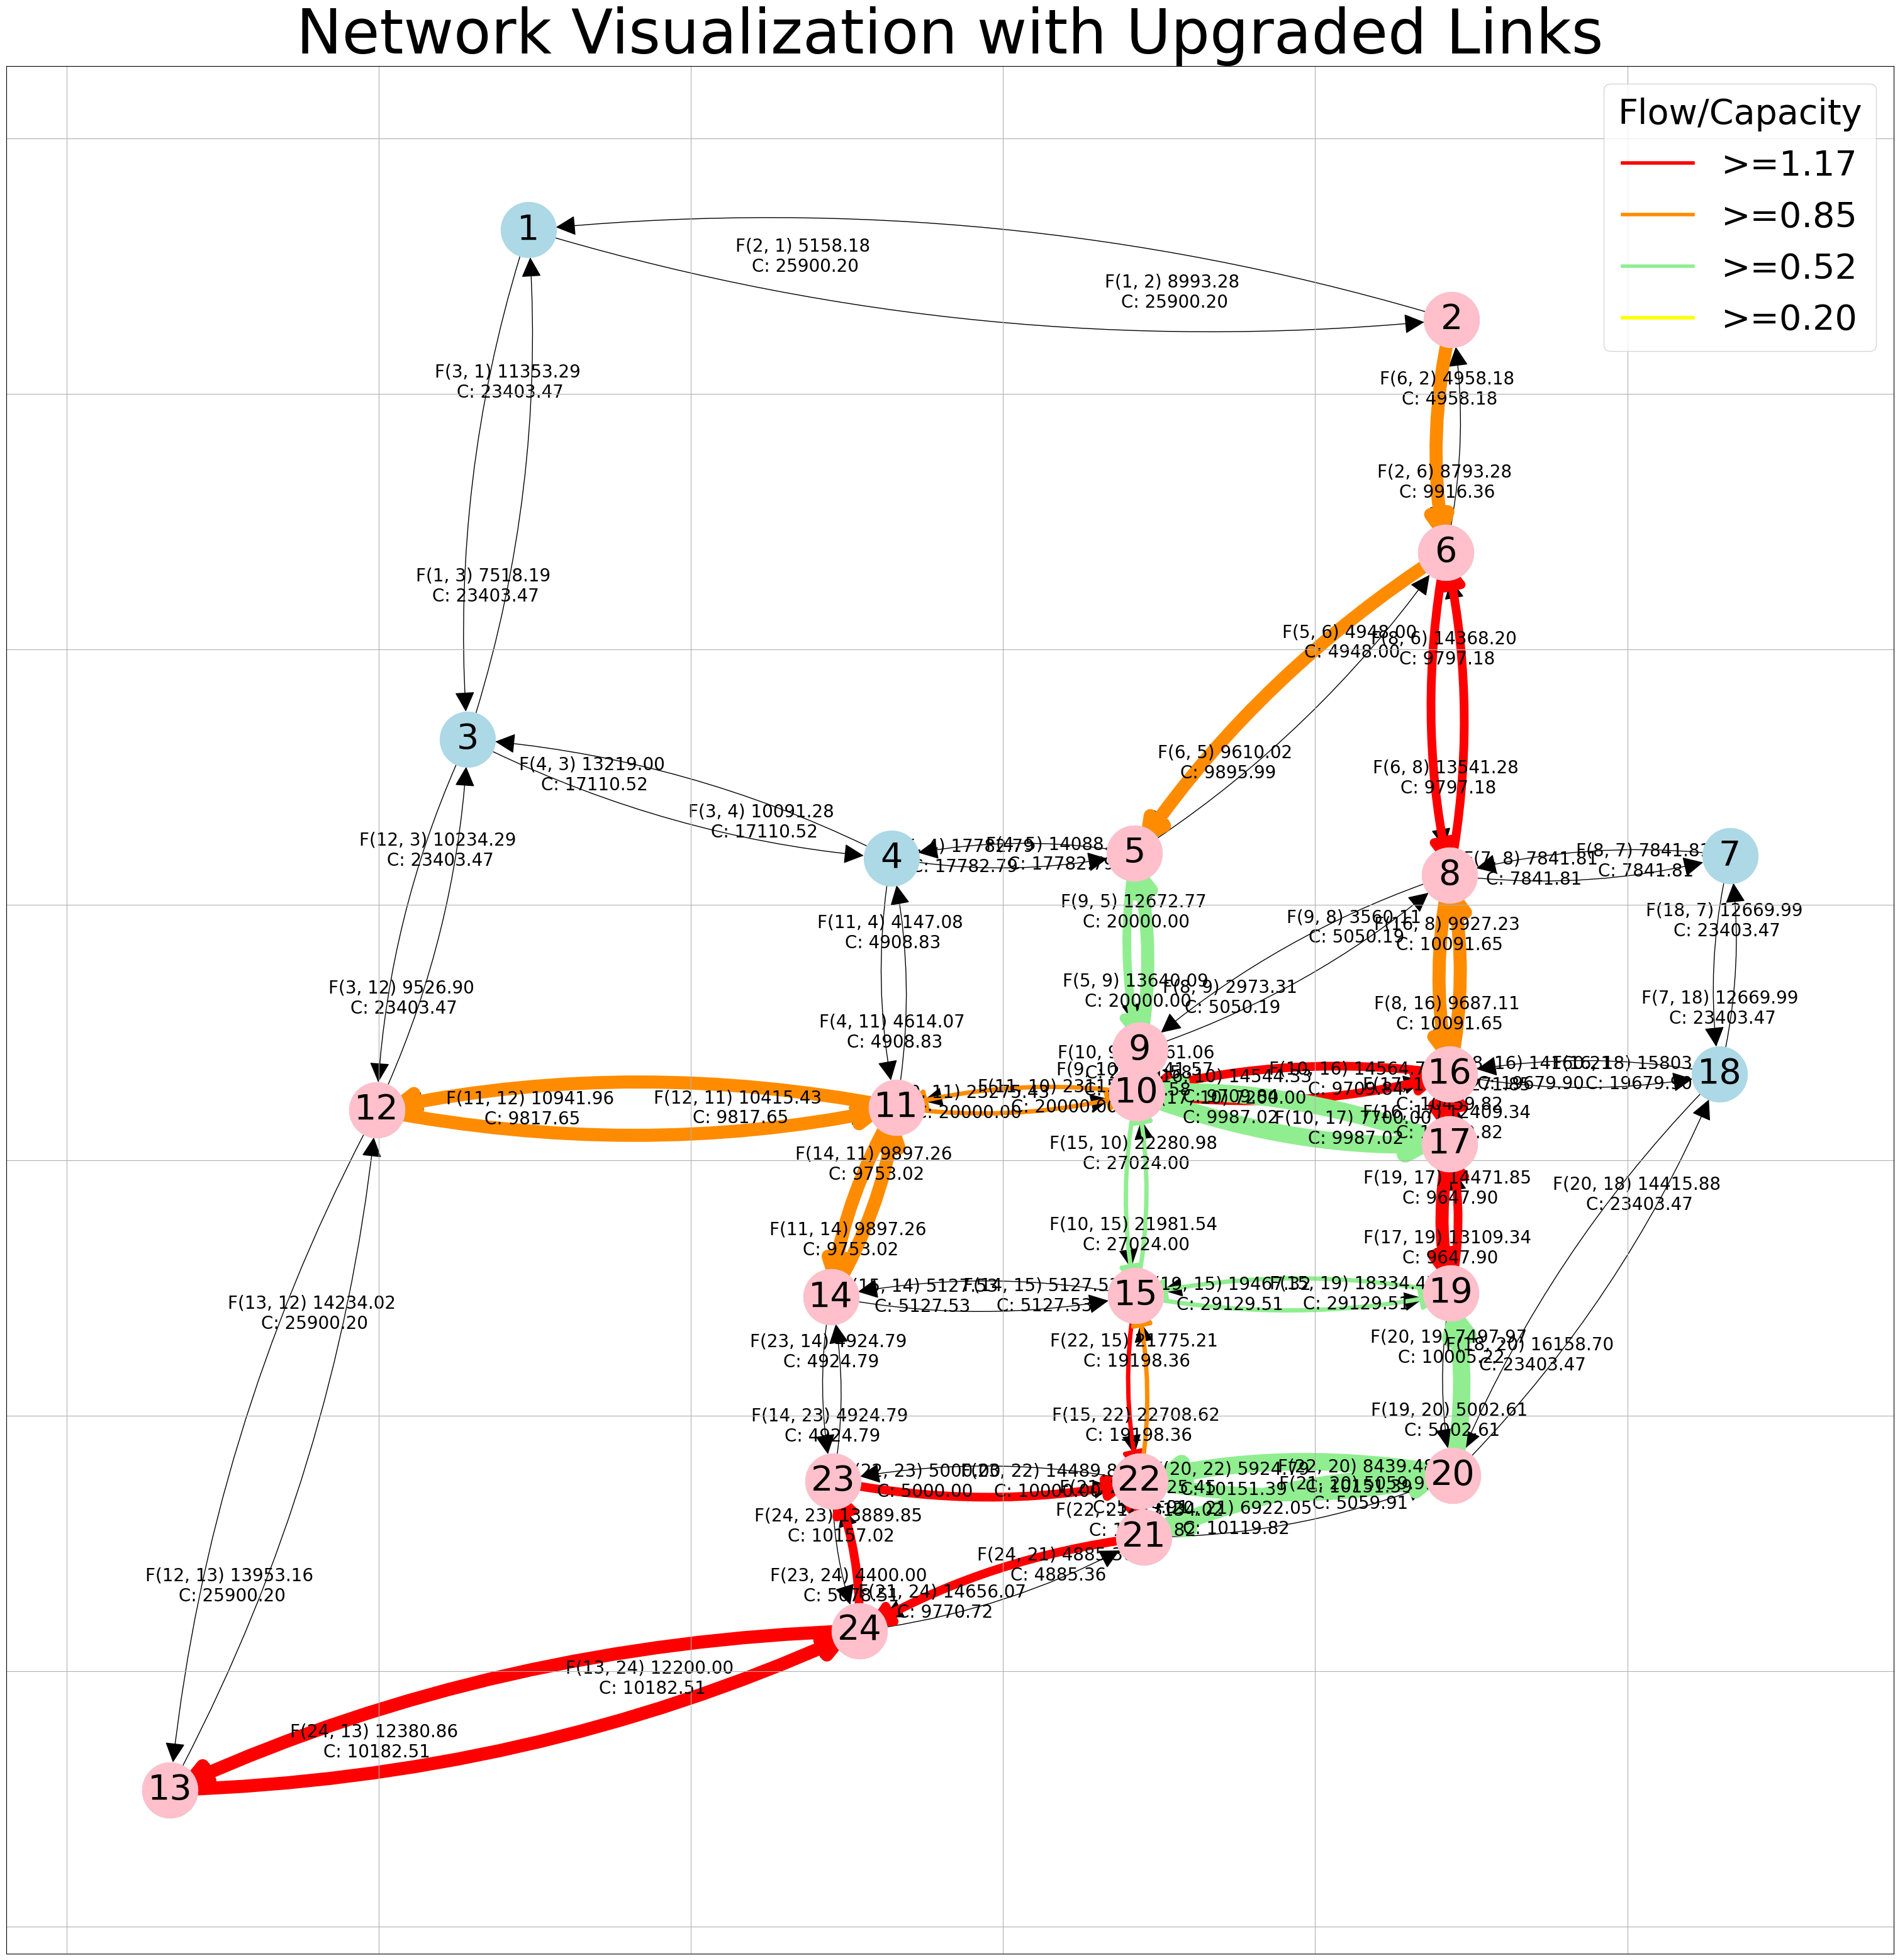

In [77]:
# To see flow and capacity for the entire network
network_visualization_upgraded (G = G, pos=pos, link_flow=link_flows, capacity_new=capacity ,link_select=links_selected, labels='on')